In [6]:
import torch, os, glob
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Ruta al directorio con los .pt (¡ajusta esta ruta!)
DATA_DIR = Path('/home/diego/Escritorio/desde_cero/AAL_116/matrix')

# Busca todos los tensores
pt_files = sorted(glob.glob(str(DATA_DIR / '*_tensor_*.pt')))
print(f'Archivos encontrados: {len(pt_files)}')

Archivos encontrados: 352


In [7]:
def load_channel_vectors(files, channel_idx=0):
    #\"\"\"Devuelve un vector 1‑D concatenado con los valores off‑diagonal
    #del canal `channel_idx` para todos los sujetos.\"\"\"
    vecs = []
    for f in files:
        data = torch.load(f, map_location='cpu')['data']  # (C, 116, 116)
        mat = data[channel_idx].numpy()
        off_diag = mat[~np.eye(mat.shape[0], dtype=bool)]
        vecs.append(off_diag)
    return np.concatenate(vecs)

# Carga cada canal
corr_vals = load_channel_vectors(pt_files, 0)   # Correlation Fisher‑Z
nmi_vals  = load_channel_vectors(pt_files, 1)   # Normalised MI
gc_vals   = load_channel_vectors(pt_files, 2)   # Granger (neg log p) (ya FDR)

for name, vals in zip(['Corr‑Z', 'NMI', 'GC‑FDR'], [corr_vals, nmi_vals, gc_vals]):
    print(f'Canal {name}: shape={vals.shape}, min={vals.min():.3f}, max={vals.max():.3f}, '
          f'mean={vals.mean():.3f}, std={vals.std():.3f}')

/tmp/ipykernel_62799/571682163.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(f, map_location='cpu')['data']  # (C, 116, 116)


Canal Corr‑Z: shape=(4695680,), min=-1.638, max=2.782, mean=0.397, std=0.346
Canal NMI: shape=(4695680,), min=0.230, max=0.694, mean=0.322, std=0.033
Canal GC‑FDR: shape=(4695680,), min=0.000, max=76.137, mean=2.747, std=4.698


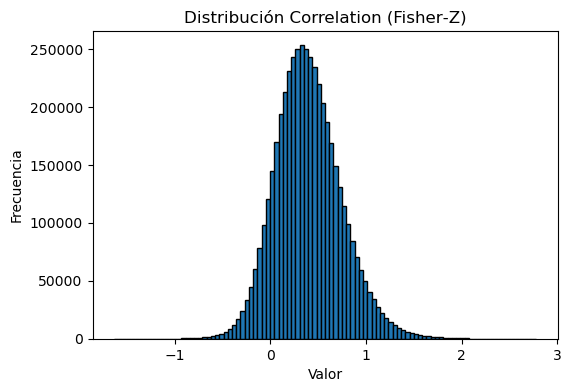

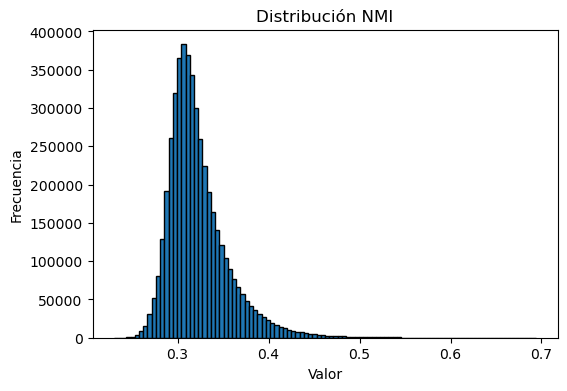

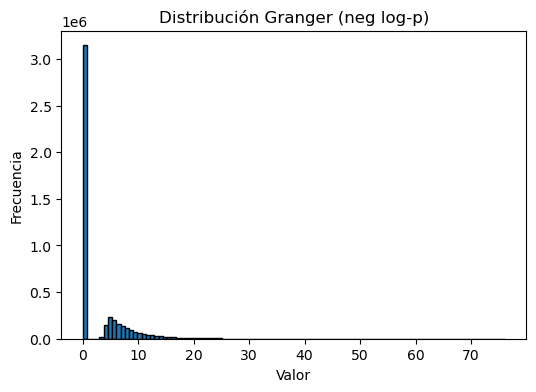

In [8]:
def plot_hist(values, title, bins=100):
    plt.figure(figsize=(6,4))
    plt.hist(values, bins=bins, edgecolor='black')
    plt.title(title)
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')
    plt.show()

plot_hist(corr_vals, 'Distribución Correlation (Fisher‑Z)')
plot_hist(nmi_vals,  'Distribución NMI')
plot_hist(gc_vals,   'Distribución Granger (neg log‑p)')

In [9]:
import pandas as pd
def summary_stats(vals):
    qs = np.percentile(vals, [0.5,1,5,25,50,75,95,99,99.5])
    return pd.Series(qs, index=['0.5%','1%','5%','25%','50%','75%','95%','99%','99.5%'])

sum_df = pd.DataFrame({
    'Corr‑Z': summary_stats(corr_vals),
    'NMI':    summary_stats(nmi_vals),
    'GC‑FDR': summary_stats(gc_vals)
})
sum_df

,Corr‑Z,NMI,GC‑FDR
0.5%,-0.426294,0.264920,0.000000
1%,-0.338929,0.269598,0.000000
5%,-0.125486,0.282458,0.000000
25%,0.161697,0.300421,0.000000
50%,0.374573,0.315089,0.000000
75%,0.608398,0.336350,5.244383
95%,0.997164,0.385934,12.013673
99%,1.327997,0.437509,19.632951
99.5%,1.467117,0.460296,23.172701


### Sugerencias para normalización\n"
"* **Correlation (Fisher‑Z):** truncar valores fuera de ±3‑4 y escalar linealmente a [‑1,1] o aplicar z‑score por canal.\n"
"* **NMI:** ya está acotada a [0,1]. Puede usarse tal cual o remapear a [‑1,1] con `x→(x‑0.5)*2`.\n"
"* **Granger:** distribución muy asimétrica (cola positiva). Considera `log1p`, clipping al p‑percentil 99 y luego `min‑max`.\n"
"* Tras pre‑procesamiento, concatena canales como tensor `(3,116,116)` y alimenta al encoder.

Leyendo .pt:   0%|          | 0/352 [00:00<?, ?it/s]

/tmp/ipykernel_62799/1990754293.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obj = torch.load(f, map_location="cpu")


mean                 std                 min            \
             mean       std      mean       std      mean       std   
channel                                                               
Corr_FZ  0.393703  0.129551  0.318417  0.045855 -0.633889  0.224857   
GC_FDR   2.723356  1.500083  4.275114  1.196475  0.000000  0.000000   
NMI      0.319449  0.012039  0.042721  0.005144  0.000000  0.000000   

               max             
              mean        std  
channel                        
Corr_FZ   2.033706   0.242175  
GC_FDR   35.895817  10.684143  
NMI       0.564535   0.045390

/tmp/ipykernel_62799/1990754293.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  for t in (torch.load(f, map_location="cpu") for f in FILES)


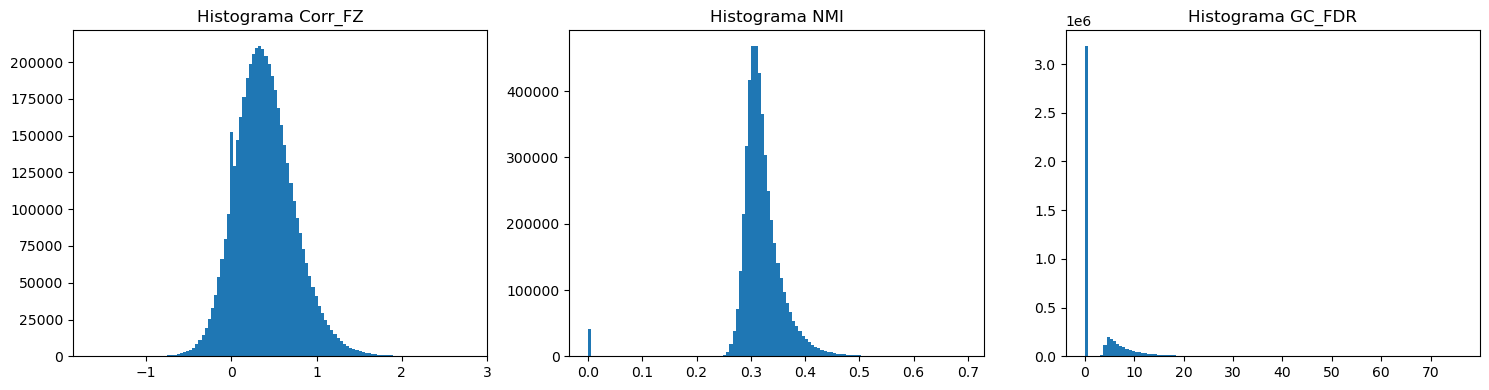

In [2]:
# eda_connectivity.py – Exploratory analysis for 3×116×116 connectivity tensors
# The file is formatted as a Jupyter‑friendly Python script ("percent" style cells).
# Replace DATA_DIR with the path where your *.pt tensors live.

# %% [markdown]
"""
Exploratory Data Analysis (EDA) for connectivity tensors
========================================================
* Loads every .pt produced by feature_extraction.py
* Computes basic statistics per channel (min, P01, median, P99, max, mean, std)
* Plots histograms of the flattened upper‑triangular values (diagonal excluded)
* Shows a heat‑map of one example matrix per channel so you can eyeball scale

Run: `ipython eda_connectivity.py` or open as notebook: `jupyter nbconvert --to notebook --execute eda_connectivity.py`.
"""

# %% Imports & configuration
import os, glob, torch, numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm.auto import tqdm

DATA_DIR = "matrix"              # ← path to your .pt tensors
# 0. Configuración
import os, glob, torch, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

DATA_DIR = "matrix/"          # ajusta la ruta
CHANNEL_NAMES = ["Corr_FZ", "NMI", "GC_FDR"]  # orden en tu pipeline
FILES = sorted(glob.glob(os.path.join(DATA_DIR, "*_tensor_*.pt")))
assert FILES, "No se encontraron .pt en DATA_DIR"

# 1. Recolección de tensores y metadatos
stats = {ch: [] for ch in CHANNEL_NAMES}
groups = []   # AD / CN / Other

for f in tqdm(FILES, desc="Leyendo .pt"):
    obj = torch.load(f, map_location="cpu")
    tensor = obj["data"].numpy()      # shape (C, 116, 116)
    meta   = obj["meta"]
    groups.append(meta["Group"])
    for i, ch in enumerate(CHANNEL_NAMES):
        flat = tensor[i].flatten()
        stats[ch].append({
            "file": os.path.basename(f),
            "mean": flat.mean(),
            "std":  flat.std(),
            "min":  flat.min(),
            "max":  flat.max(),
            "q1":   np.quantile(flat, 0.25),
            "median": np.quantile(flat, 0.50),
            "q3":   np.quantile(flat, 0.75)
        })

# 2. Tabla resumen
df_list = [pd.DataFrame(stats[ch]).assign(channel=ch) for ch in CHANNEL_NAMES]
df = pd.concat(df_list, ignore_index=True)
display(df.groupby("channel")[["mean","std","min","max"]].agg(["mean","std"]))

# 3. Histogramas por canal
fig, axes = plt.subplots(1, len(CHANNEL_NAMES), figsize=(5*len(CHANNEL_NAMES),4))
for ax, ch in zip(axes, CHANNEL_NAMES):
    all_vals = np.concatenate([t["data"][i].flatten()
                               for t in (torch.load(f, map_location="cpu") for f in FILES)
                               for i,ch_name in enumerate(CHANNEL_NAMES) if ch_name==ch])
    ax.hist(all_vals, bins=120)
    ax.set_title(f"Histograma {ch}")
plt.tight_layout()

